In [1]:
import chirho.observational.handlers
import pyro
import torch
import pyro.distributions as dist
from chirho.interventional.handlers import Interventions, do
from chirho.counterfactual.handlers.counterfactual import TwinWorldCounterfactual
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.indexed.ops import gather, IndexSet
from functools import singledispatch
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal, AutoNormal
from functools import partial
from chirho.indexed.ops import gather, IndexSet
from chirho.observational.handlers import condition
from chirho.observational.handlers.condition import Observations
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, sqrt
from itertools import product
from random import randint
from contextlib import nullcontext
import matplotlib
from utils.build_svi_iter import build_svi_iter
from chirho.observational.handlers.predictive import PredictiveModel
import seaborn as sns
pyro.settings.set(module_local_params=True)

# seed = randint(0, int(1e6))
# print(seed)
seed = 715440

pyro.set_rng_seed(seed)

# Partial Missingness and Informative Data
In this notebook, we'll establish a simple causal model where some of the data is missing. We expect that the data-sensitivity should be larger for data with no missingness, and smaller — but still non-zero — for data with missingness. 

In [2]:
VEC_DIM = -1
MAT_DIM = -2
DATA_DIM = -3
MC_DIM = -4
NUM_CONFOUNDERS = 100
NUM_OUTCOME = 1
NUM_TREATMENT = 30


def missingness_likelihood_model(
        treatment_coefficients,  # (..., NUM_CONFOUNDERS, NUM_TREATMENT)
        confounder_coefficients,  # (..., NUM_CONFOUNDERS, 1)
        missingness_coefficients,  # (..., NUM_CONFOUNDERS + NUM_TREATMENT, 1)
        outcome_coefficients  # (..., NUM_CONFOUNDERS + NUM_TREATMENT, NUM_OUTCOME)
):
    
    assert treatment_coefficients.shape[-2:] == (NUM_CONFOUNDERS, NUM_TREATMENT),\
        f"Treatment coefficients shape: {treatment_coefficients.shape}"
    assert confounder_coefficients.shape[-2:] == (NUM_CONFOUNDERS, 1),\
        f"Confounder coefficients shape: {confounder_coefficients.shape}"
    assert missingness_coefficients.shape[-2:] == (NUM_CONFOUNDERS + NUM_TREATMENT, 1),\
        f"Missingness coefficients shape: {missingness_coefficients.shape}"
    assert outcome_coefficients.shape[-2:] == (NUM_CONFOUNDERS + NUM_TREATMENT, NUM_OUTCOME),\
        f"Outcome coefficients shape: {outcome_coefficients.shape}"
    
    confounders = pyro.sample("conf", dist.Normal(confounder_coefficients, 1))
    assert confounders.shape[-2:] == (NUM_CONFOUNDERS, 1), f"Confounders shape: {confounders.shape}"
    
    treatment_means = treatment_coefficients.transpose(-2, -1) @ confounders
    assert treatment_means.shape[-2:] == (NUM_TREATMENT, 1), f"Treatment means shape: {treatment_means.shape}"
    
    treatment = pyro.sample("treat", dist.Normal(treatment_means, 1))
    assert treatment.shape[-2:] == (NUM_TREATMENT, 1), f"Treatment shape: {treatment.shape}"
    
    # HACK treatment may have been intervened on and have had dimensions added on the left. This breaks the cats below.
    # To resolve, expand the left dimensions of the confounders to match the treatment dimensions.
    if len(treatment.shape) > len(confounders.shape):
        # HACK hardcoding a single left split dimension.
        confounders = confounders[None, ...].expand((treatment.shape[0],) + (-1,) * (len(treatment.shape) - 1))
    
    missingness_logit = missingness_coefficients.transpose(-2, -1) @ torch.cat([confounders, treatment], dim=-2)
    assert missingness_logit.shape[-2:] == (1, 1), f"Missingness logit shape: {missingness_logit.shape}"
    
    missingness = pyro.sample("miss", dist.Bernoulli(logits=missingness_logit))
    assert missingness.shape[-2:] == (1, 1), f"Missingness shape: {missingness.shape}"
    
    outcome_means = outcome_coefficients.transpose(-2, -1) @ torch.cat([confounders, treatment], dim=-2)
    assert outcome_means.shape[-2:] == (NUM_OUTCOME, 1), f"Outcome means shape: {outcome_means.shape}"
    
    # HACK to make outcome still be computationally non-deterministic (so we can condition on it) when missingness is zero.
    outcome = pyro.sample("out", dist.Normal(outcome_means * missingness, 1. * missingness + 1e-3))
    assert outcome.shape[-2:] == (NUM_OUTCOME, 1), f"Outcome shape: {outcome.shape}"
    
    return dict(
        conf=confounders,
        treat=treatment,
        miss=missingness,
        out=outcome
    )

In [3]:
def coefficient_prior():
    with pyro.plate("conf_plate", NUM_CONFOUNDERS, dim=MAT_DIM):
        confounder_coefficients = pyro.sample("confounder_coefficients", dist.Normal(0, 1.))
    
        with pyro.plate("treat_plate", NUM_TREATMENT, dim=VEC_DIM):
            treatment_coefficients = pyro.sample("treatment_coefficients", dist.Normal(0., 1))
    
    with pyro.plate("conf_treat_plate", NUM_CONFOUNDERS + NUM_TREATMENT, dim=MAT_DIM):
        missingness_coefficients = pyro.sample("missingness_coefficients", dist.Normal(0., 1.))
        
        with pyro.plate("out_plate", NUM_OUTCOME, dim=VEC_DIM):
            outcome_coefficients = pyro.sample("outcome_coefficients", dist.Normal(0., 1.))
    
    return dict(
        confounder_coefficients=confounder_coefficients,
        treatment_coefficients=treatment_coefficients,
        missingness_coefficients=missingness_coefficients,
        outcome_coefficients=outcome_coefficients
    )

In [4]:
def full_missingness_model(num_data=1):
    coefficients = coefficient_prior()
    
    with pyro.plate("data", num_data, dim=DATA_DIM):
        return missingness_likelihood_model(**coefficients), coefficients

In [5]:
NOBSERVED = 200
observed_data, true_coefficients = full_missingness_model(NOBSERVED)
print("Observed data shapes:")
print('\n'.join([str((k, v.shape)) for k, v in observed_data.items()]))
print("True coefficients shapes:")
print('\n'.join([str((k, v.shape)) for k, v in true_coefficients.items()]))

Observed data shapes:
('conf', torch.Size([200, 100, 1]))
('treat', torch.Size([200, 30, 1]))
('miss', torch.Size([200, 1, 1]))
('out', torch.Size([200, 1, 1]))
True coefficients shapes:
('confounder_coefficients', torch.Size([100, 1]))
('treatment_coefficients', torch.Size([100, 30]))
('missingness_coefficients', torch.Size([130, 1]))
('outcome_coefficients', torch.Size([130, 1]))


In [6]:
print(f"Missingness rate: {1. - observed_data['miss'].mean().item():.2%}")

Missingness rate: 87.50%


In [7]:
# for treatment_idx in range(NUM_TREATMENT):
#     plt.scatter(observed_data["treat"].detach()[..., treatment_idx, 0], observed_data["out"].detach()[..., 0, 0], c=observed_data["miss"].detach()[..., 0, 0])
#     plt.xlabel("Treatment")
#     plt.ylabel("Outcome")
#     plt.title(f"Treatment {treatment_idx}")
#     plt.show()

### Stochastic Variational Inference

In [8]:
conditioned_missingness_model = condition(partial(full_missingness_model, NOBSERVED), data=observed_data)

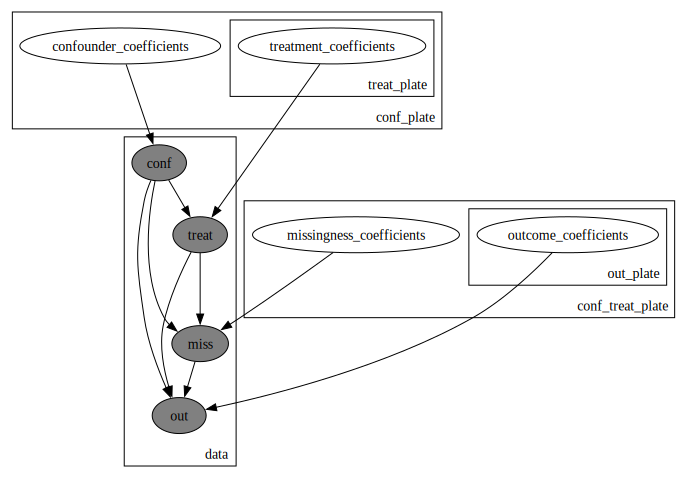

In [9]:
pyro.render_model(conditioned_missingness_model)

In [ ]:
svi = build_svi_iter(
    conditioned_missingness_model,
    AutoMultivariateNormal,
    lr=2e-3
)
NITER = 4000
for i in range(NITER):
    svi.svi_iter()
    print(f"Progress {(i+1)/NITER:.2%}", end="\r")

In [ ]:
plt.plot(svi.losses)

### Check Performance of Plug-In Estimator


In [ ]:
class MultivariateTreatmentGrid(torch.nn.Module):
    def __init__(self, model, values, num_monte_carlo: int = 100, results_shaper=None, constant_idices=None, generate_product_values=False):
        super().__init__()
        self.model = model
        self.num_monte_carlo = num_monte_carlo
        self.results_shaper = results_shaper or (lambda x: x)
        self.constant_idices = constant_idices or {}
        
        if generate_product_values:
            # Expand values over the grid of treatments.
            product_values = []
            for value in product(values, repeat=NUM_TREATMENT):
                # HACK manually specifying the broadcast shape...
                product_values.append(torch.tensor(value)[None, None, :, None])
            assert len(product_values) == 2 ** NUM_TREATMENT
            
            self.product_values = tuple(product_values)
        else:
            # HACK manually specifying the broadcast shape...
            self.product_values = tuple(v[None, None, :, None] for v in values)
    
    def forward(self, *args, **kwargs):
        with MultiWorldCounterfactual():
            with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=MC_DIM):
                with do(actions=dict(treat=self.product_values)):
                    predictive_samples, coefficient_samples = self.model(*args, **kwargs)
                    Ys = predictive_samples["out"]
                
                outs = []
                for i, _ in enumerate(self.product_values):
                    idx_set = IndexSet(treat={i+1}, **self.constant_idices)
                    outs.append(gather(Ys, idx_set))
                    
        return self.results_shaper(outs)

In [ ]:
def reshape_results_to_mean(results):
    results = torch.cat(results, dim=0)  # (len(product_values), num_monte_carlo, num_data, NUM_OUTCOME, 1)
    return results.squeeze(-1).mean(-2).mean(-2)  # (len(product_values), NUM_OUTCOME)

def reshape_results_to_estimates(results):
    results = torch.cat(results, dim=0)  # (len(product_values), num_monte_carlo, num_data, NUM_OUTCOME, 1)
    results = results.squeeze(-1).transpose(-1, 1)  # (len(product_values), NUM_OUTCOME, num_monte_carlo, num_data)
    return results.reshape(results.shape[:2] + (-1,))

NMC = 1e2
NBD = 1
# intervention_values = (-10., 10.)
intervention_values = (torch.ones(NUM_TREATMENT) * -10., torch.ones(NUM_TREATMENT) * 10.)

In [ ]:
full_missingness_model_wo_missingness = do(full_missingness_model, {"miss": torch.tensor(1.)})

In [ ]:
true_model = condition(full_missingness_model_wo_missingness, data=true_coefficients)
true_results = MultivariateTreatmentGrid(
    true_model,
    intervention_values,
    num_monte_carlo=NMC,
    constant_idices=dict(miss={1})
)(num_data=NBD)
true_result_estimates = reshape_results_to_estimates(true_results)
print(true_result_estimates.shape)

In [ ]:
posterior_predictive_model = PredictiveModel(full_missingness_model_wo_missingness, svi.guide)
posterior_results = MultivariateTreatmentGrid(
    posterior_predictive_model,
    intervention_values,
    num_monte_carlo=NMC,
    constant_idices=dict(miss={1})
)(num_data=NBD)
posterior_result_estimates = reshape_results_to_estimates(posterior_results)
print(posterior_result_estimates.shape)

In [ ]:
prior_predictive_model = full_missingness_model
prior_results = MultivariateTreatmentGrid(
    full_missingness_model_wo_missingness,
    intervention_values,
    num_monte_carlo=NMC,
    constant_idices=dict(miss={1})
)(num_data=NBD)
prior_result_estimates = reshape_results_to_estimates(prior_results)
print(prior_result_estimates.shape)

In [ ]:
def plot_intervention_outcome_grid(*results):
    num_interventions = results[0].shape[0]
    num_outcomes = results[0].shape[1]
    fig, axs = plt.subplots(num_outcomes, num_interventions, figsize=(num_interventions * 5, num_outcomes * 5), sharey=True, sharex=True)
    
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])
    if axs.ndim == 1:
        axs = axs[None, :]
    
    for i, j in product(range(num_interventions), range(num_outcomes)):
        mean = results[0][i, j].mean().item()
        axs[j, i].axvline(mean, color="black", linestyle="--")
        
        for result in results:
            sns.kdeplot(result[i, j].detach().numpy(), ax=axs[j, i], fill=False)
        
        
    return fig, axs

In [ ]:
_, axs = plot_intervention_outcome_grid(true_result_estimates, posterior_result_estimates, prior_result_estimates)
# Add legend to the first plot.
axs[0, 0].legend(["True Effect", "True", "Post Pred", "Prior Pred"])

### TODO Add Robust Estimator to Above